# The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

## Inspecting the data of the Jena weather dataset

We’ll work with a weather timeseries dataset recorded at the weather station at the
Max Planck Institute for Biogeochemistry in Jena, Germany.1
 In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on)
were recorded every 10 minutes over several years. The original data goes back to
2003, but the subset of the data we’ll download is limited to 2009–2016.

In [1]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

In [2]:
import os

fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
    
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


## Parsing the data

In [3]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

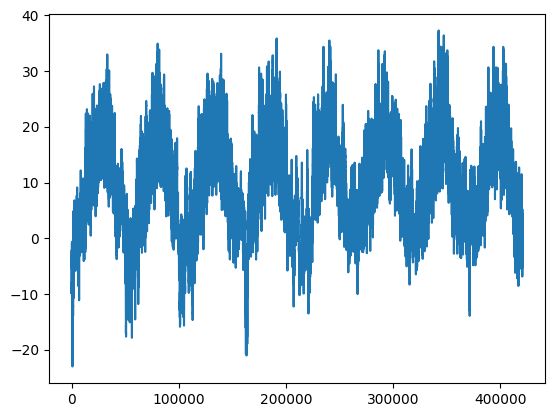

In [4]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

- Fig shows a plot of temperature (in degrees Celsius) over time. On this plot,
you can clearly see the yearly periodicity of temperature—the data spans 8 years.

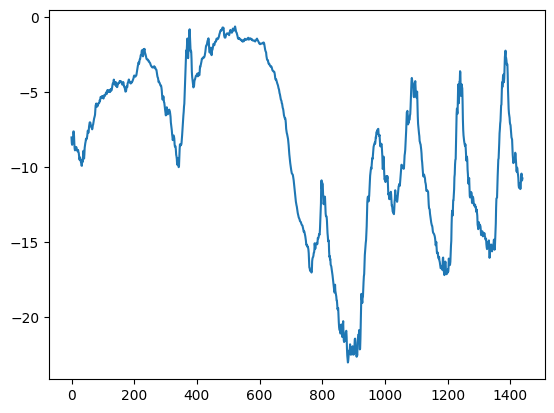

In [5]:
plt.plot(range(1440), temperature[:1440])


- Fig shows a more narrow plot of the first 10 days of temperature data. Because
the **data is recorded every 10 minutes** , you get 24 × 6 = 144 data points per day.

- In all our experiments, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries
data, **it’s important to use validation and test data that is more recent than the training data**, because you’re trying to predict the future given the past, not the reverse,
and your validation/test splits should reflect that.

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

## Normalizing the data

## 

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

## Instantiating datasets for training, validation, and testing


- sampling_rate = 6 — Observations will be sampled at one data point per hour:we will only keep one data point out of 6.
- sequence_length = 120 — Observations will go back 5 days (120 hours).
- delay = sampling_rate * (sequence_length + 24 - 1)—The target for a sequence
will be the temperature 24 hours after the end of the sequence.

In [8]:
import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset   = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)


val_dataset =   keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples    +  num_val_samples)


test_dataset    =  keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples  +    num_val_samples)

2025-01-13 23:49:16.416009: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 23:49:16.419388: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 23:49:16.426315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736812156.436920   32131 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736812156.440041   32131 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 23:49:16.456879: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

2025-01-13 23:49:19.235949: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23545200 exceeds 10% of free system memory.


samples shape: (256, 120, 14)
targets shape: (256,)


## Computing the common-sense baseline MAE

a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature
right now. 

In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

2025-01-13 23:49:30.676061: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation MAE: 2.44
Test MAE: 2.62


2025-01-13 23:49:50.215337: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training and evaluating a densely connected model


In [11]:
# Importa a API Keras do TensorFlow e o módulo de camadas
from tensorflow import keras
from keras import layers

# Define a entrada do modelo com a forma (sequence_length, número de recursos por passo de tempo)
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.GlobalAveragePooling1D()(inputs)

# x = layers.Flatten()(inputs)

# Adiciona uma camada densa totalmente conectada com 16 neurônios e ativação ReLU
x = layers.Dense(16, activation="tanh")(x)

# Adiciona a camada de saída com 1 neurônio (para prever um valor contínuo)
outputs = layers.Dense(1)(x)

# Cria o modelo combinando as entradas e saídas
model = keras.Model(inputs, outputs)

# Define os callbacks; aqui, salva o melhor modelo durante o treinamento no arquivo 'jena_dense.keras'
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)  # Salva apenas o melhor modelo
]

# Compila o modelo especificando o otimizador, a função de perda e as métricas
model.compile(
    optimizer="rmsprop",     # Otimizador RMSprop
    loss="mse",              # Função de perda: erro quadrático médio (MSE)
    metrics=["mae"]          # Métrica: erro absoluto médio (MAE)
)

model.summary()

# Treina o modelo usando os dados de treinamento e validação
history = model.fit(
    train_dataset,           # Conjunto de dados de treinamento
    epochs=10,               # Número de épocas de treinamento
    validation_data=val_dataset,  # Conjunto de validação
    callbacks=callbacks      # Callback para salvar o melhor modelo
)

# Carrega o modelo salvo com o melhor desempenho (salvo pelo callback)
model = keras.models.load_model("jena_dense.keras")

# Avalia o modelo no conjunto de teste e imprime o erro absoluto médio (MAE)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 14)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257 (1.00 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 92.5570 - mae: 7.8769 - val_loss: 22.3529 - val_mae: 3.6914
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - loss: 22.7988 - mae: 3.8041 - val_loss: 20.4929 - val_mae: 3.5597
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 21.8789 - mae: 3.7356 - val_loss: 19.8846 - val_mae: 3.5097
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 21.6905 - mae: 3.7212 - val_loss: 19.7207 - val_mae: 3.4937
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 21.5681 - mae: 3.7098 - val_loss: 19.8661 - val_mae: 3.5046
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 21.5017 - mae: 3.7021 - val_loss: 19.7612 - val_mae: 3.4975
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 21.4426 - mae: 3.6968 - val_loss: 19.9805 - val_mae: 3.5182
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 21.3736 - mae: 3.6905 - val_loss: 19.8888 - val_mae: 3.5100
Epoch 9/10
819/819 ━━━━━

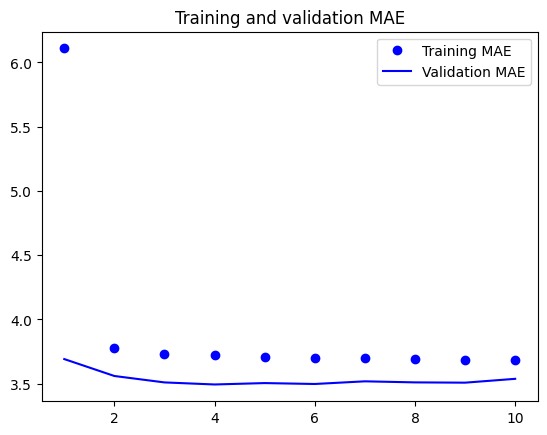

In [12]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## A simple LSTM-based model

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
            keras.callbacks.ModelCheckpoint("jena_lstm.keras",
            save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
            epochs=10,
            validation_data=val_dataset,
            callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 62s 74ms/step - loss: 76.3523 - mae: 6.6887 - val_loss: 13.0203 - val_mae: 2.7356
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 61s 75ms/step - loss: 11.8577 - mae: 2.6620 - val_loss: 9.7426 - val_mae: 2.4248
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 10.0191 - mae: 2.4737 - val_loss: 9.6257 - val_mae: 2.4036
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - loss: 9.6487 - mae: 2.4254 - val_loss: 9.3841 - val_mae: 2.3638
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - loss: 9.4010 - mae: 2.3932 - val_loss: 9.4459 - val_mae: 2.3643
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 9.0902 - mae: 2.3512 - val_loss: 9.4352 - val_mae: 2.3710
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 61s 75ms/step - loss: 8.9039 - mae: 2.3246 - val_loss: 9.4617 - val_mae: 2.3734
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - loss: 8.7613 - mae: 2.3030 - val_loss: 9.6329 - val_mae: 2.3990
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━

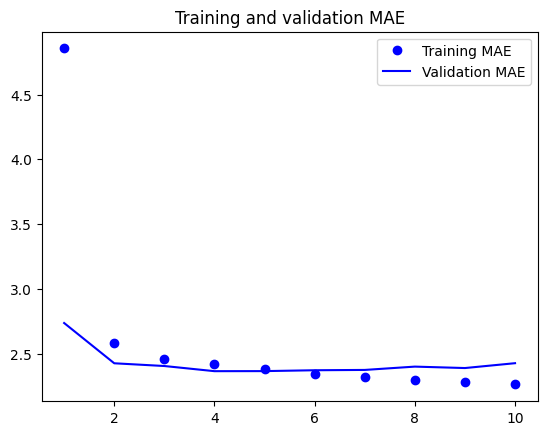

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()